# Assignment 8: D-Prime Plot
## Computational Methods in Psychology (and Neuroscience)
### Psychology 4500/7559 --- Fall 2020


# Objectives

Upon completion of this assignment, students will have:

1. Read in all the recognition memory data
2. Performed some simple data clean-up (code provided)
3. Calculated d-prime for the word recognition task
4. Plotted d-prime as a function of valence and condition

# Assignment

* Write code in a Jupyter notebook (after making a copy and renaming it to have your userid in the title --- e.g., A08_DPrime_Plot_mst3k).


## Details

Below is code that will load in the data from the two recognition memory experiments. As long as you have updated this repository from GitHub and unzipped the `all_data.zip` file in the `lessons` directory, the code should work unchanged to load in the data, create two data frames, and perform some minor clean-up of the data.

Your task is to calculate d-prime for the word recognition data and then plot the result as a function of valence (negative, neutral, positive) and condition (mixed and pure).

All the code you need to perform this analysis is in the most recent lesson notebook. You will need to identify the correct pieces of code to copy into this notebook and how to modify it to examine valence as opposed to image location. 

We have some code below to help you get started reading in the data, so that you can focus on the d-prime calculation and plot.

* ***When you are done, save this notebook as HTML (`File -> Download as -> HTML`) and upload it to the matching assignment on UVACollab.***  

# New library to install

You're going to need a new plotting library, so run this line at your Anaconda Prompt/Terminal:

`conda install -c conda-forge plotnine` 

## General Imports

In [78]:
# import some useful libraries
import numpy as np                # numerical analysis linear algebra
import pandas as pd               # efficient tables
import matplotlib.pyplot as plt   # plotting
import plotnine as pn 
import scipy.stats.distributions as dists     # probability distributions
from scipy import stats
from glob import glob
import os

from smile.log import log2dl

from ci_within import ci_within

## Custom SLOG loading function

In [79]:
# custom function to load slogs
def load_all_subj_logs(task_dir, log_file):
    # load in a list of all the subj
    subjs = [os.path.split(subj_dir)[-1] 
             for subj_dir in glob(os.path.join(task_dir, 's*'))]
    subjs.sort()

    # loop over subj and their data
    all_dat = []
    for subj in subjs:
        # set the file
        log_path = os.path.join(task_dir, subj, log_file)
        #print(log_path)

        # load the data
        all_dat.extend(log2dl(log_path, subj=subj))

    df = pd.DataFrame(all_dat)
    
    return df

## Load in all the data

In [80]:
# load the data from the word recog task
task_dir = os.path.join('..', 'lessons', 'data2', 'Taskapalooza')

df_w = load_all_subj_logs(task_dir, 'log_word_test')
df_w.head()

,resp_map_lure,resp_map_target,block_num,trial_num,stim_on_time,stim_on_error,resp,resp_time_time,resp_time_error,rt,...,valence_sd,arousal_mean,arousal_sd,dominance_mean,dominance_sd,word_frequency,novelty,cond,subj,log_num
0,F,J,0,0,234.395511,0.0,J,235.284833,0.000180,0.889323,...,1.5700000000000001,5.3099999999999996,2.23,5.46,2.0499999999999998,3,target,neu,s001,0
1,F,J,0,1,235.885654,0.0,F,237.034670,0.000182,1.149016,...,1.5,4.1200000000000001,1.8300000000000001,5.6600000000000001,1.78,12,lure,neu,s001,0
2,F,J,0,2,237.616869,0.0,F,238.767406,0.000238,1.150537,...,1.8200000000000001,5.4500000000000002,2.1499999999999999,4.6399999999999997,2.0699999999999998,16,lure,neu,s001,0
3,F,J,0,3,239.624933,0.0,F,240.432295,0.000182,0.807362,...,1.24,3.9500000000000002,2.5800000000000001,5.3700000000000001,1.6399999999999999,19,lure,neu,s001,0
4,F,J,0,4,241.432209,0.0,F,242.545227,0.000192,1.113017,...,2.1600000000000001,3.6800000000000002,2.5699999999999998,5.8300000000000001,1.5,49,lure,neu,s001,0


## Some data clean-up

In [81]:
# it turns out the cond is easier to visualize as pure and mixed
def fix_conds(df, type_col):
    # loop over the unique subjects
    usubj = df.subj.unique()
    for s in usubj:
        # loop over their blocks
        ublocks = df.loc[df['subj']==s, 'block_num'].unique()
        for b in ublocks:
            # grab the data for that subj and block
            dfb = df.loc[(df['subj']==s)&(df['block_num']==b)]
            
            # get the unique types in that block
            uval = dfb[type_col].unique()
            if len(uval) > 1:
                # it's mixed
                df.loc[(df['subj']==s)&(df.block_num==b), 'cond'] = 'mixed'
            else:
                # it's the pure
                df.loc[(df['subj']==s)&(df.block_num==b), 'cond'] = 'pure'

# fix the conds in the recog experiments (updated in place)
fix_conds(df_w, type_col='valence')


# add in log_rt columns
df_w['log_rt'] = np.log(df_w['rt'])

# must make correct an int
df_w['correct'] = df_w['correct'].astype(np.int)

# add in a column for whether they made an 'old' response
df_w['old_resp'] = (df_w['resp_map_target'] == df_w['resp']).astype(np.int)

## Calculating sensitivity

- Under assumptions of equal variance for both the signal and noise distributions, the d' (d-prime) is the measure of sensitivity

$$d' = ((\mu + \alpha) - \mu) / \sigma$$
$$d' = \alpha / \sigma$$

- Thus, $d'$ is the difference between the two distributions in units of the standard deviation
- Note, this is independent of the criterion


In [82]:
def calc_dprime(n_hits, n_targets, n_false_alarms, n_lures):
    # calculate corrected hit rate and false alarm rate (to avoid zeros)
    hr_trans = (n_hits+.5)/(n_targets+1)
    far_trans = (n_false_alarms+.5)/(n_lures+1)
    
    # calculate dprime
    Z = dists.norm.ppf
    dprime = Z(hr_trans) - Z(far_trans)
    return dprime

# Your code goes below here

All code above should work without modification.

In [83]:
# use the agg method to get the counts
iperf = df_w.groupby(['subj', 'cond', 'valence', 'novelty'])['old_resp'].agg(['sum', 'count', 'mean'])
iperf = iperf.unstack().reset_index()
iperf.head()

subj   cond valence  sum        count             mean          
novelty                      lure target  lure target      lure    target
0        s001  mixed     neg    2     26    32     32  0.062500  0.812500
1        s001  mixed     neu    3     28    32     32  0.093750  0.875000
2        s001  mixed     pos    1     26    32     32  0.031250  0.812500
3        s001   pure     neg    4     37    48     48  0.083333  0.770833
4        s001   pure     neu    2     40    48     48  0.041667  0.833333

In [84]:
# collapse the multi-index


iperf.columns = ['_'.join(col).strip() if len(col[1]) > 0 else col[0] 
                 for col in iperf.columns.values]
iperf.head()

,subj,cond,valence,sum_lure,sum_target,count_lure,count_target,mean_lure,mean_target
0,s001,mixed,neg,2,26,32,32,0.062500,0.812500
1,s001,mixed,neu,3,28,32,32,0.093750,0.875000
2,s001,mixed,pos,1,26,32,32,0.031250,0.812500
3,s001,pure,neg,4,37,48,48,0.083333,0.770833
4,s001,pure,neu,2,40,48,48,0.041667,0.833333


In [85]:
# use apply to add the dprime as a new column (axis=1 tells it to go by row)

# add the dprime as a new column (axis=1 tells it to go by row)
iperf['dprime'] = iperf.apply(lambda x: calc_dprime(x['sum_target'], x['count_target'],
                                                    x['sum_lure'], x['count_lure']),
                                  axis=1)

iperf

,subj,cond,valence,sum_lure,sum_target,count_lure,count_target,mean_lure,mean_target,dprime
0,s001,mixed,neg,2,26,32,32,0.062500,0.812500,2.286695
1,s001,mixed,neu,3,28,32,32,0.093750,0.875000,2.344557
2,s001,mixed,pos,1,26,32,32,0.031250,0.812500,2.543117
3,s001,pure,neg,4,37,48,48,0.083333,0.770833,2.053005
4,s001,pure,neu,2,40,48,48,0.041667,0.833333,2.575583
...,...,...,...,...,...,...,...,...,...,...
133,s023,mixed,neu,3,22,32,32,0.093750,0.687500,1.720543
134,s023,mixed,pos,8,28,32,32,0.250000,0.875000,1.747641
135,s023,pure,neg,19,30,48,48,0.395833,0.625000,0.570552
136,s023,pure,neu,15,38,48,48,0.312500,0.791667,1.269635


In [86]:
# use ci_within to calcuate the mean and confidence interval of d-prime


res = ci_within(iperf, indexvar='subj', 
                withinvars=['cond', 'valence'], 
                measvar='dprime').reset_index()
res

,cond,valence,mean,std,sem,ci,len
0,mixed,neg,2.137170,0.430340,0.089732,0.186093,23.0
1,mixed,neu,2.161265,0.431411,0.089955,0.186556,23.0
2,mixed,pos,1.932844,0.443766,0.092532,0.191899,23.0
3,pure,neg,2.068016,0.473188,0.098667,0.204622,23.0
4,pure,neu,2.173517,0.621585,0.129609,0.268793,23.0
5,pure,pos,2.085244,0.633626,0.132120,0.274000,23.0


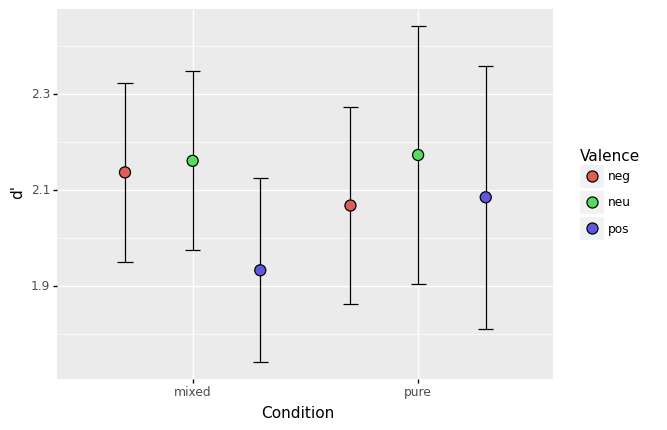

<ggplot: (7007483225)>

In [87]:
# use plotnine to plot dprime as a function of condition, with a fill-color defined by valence
# be sure to label your axes correctly and add the confidence interval with error bars

p = (pn.ggplot(res, pn.aes('cond', 'mean', fill='valence'))
     + pn.geom_errorbar(pn.aes(ymin='mean-ci', ymax='mean+ci', width=0.2), 
                        position=pn.position_dodge(.9))
     + pn.geom_point(position=pn.position_dodge(.9), size=4)
     + pn.labs(x="Condition", y = "d'", fill='Valence')
    )
p